# California House Price Analysis

- **Dataset(s) to be used:** [Kaggle California House Prices](https://www.kaggle.com/datasets/shibumohapatra/house-price)
- **Analysis question:** Are house prices in coastal areas significantly higher than inland areas?
- **Columns that will be used:**
  - longitude
  - latitude
  - median_house_value
  - ocean_proximity
  - median_income
- **Hypothesis:** House prices in coastal areas are significantly higher than inland areas and positively correlated with income levels
- **Site URL:** https://inafu6006-hw.readthedocs.io/en/latest/project_3/code.html

## Introduction


The California House Price dataset, available from [Kaggle](https://www.kaggle.com/datasets/shibumohapatra/house-price), provides comprehensive information about housing districts across California. This dataset contains 20,640 observations at the block group level, which is the smallest geographical unit for which the US Census Bureau publishes sample data. Each observation includes geographic coordinates (longitude and latitude), housing characteristics (median house value, housing median age), demographic information (population, households, median income), and ocean proximity categories that classify locations as NEAR BAY, NEAR OCEAN, <1H OCEAN, or INLAND.

Our research focuses on investigating the relationship between house prices and coastal proximity in California. We hypothesize that coastal properties command significantly higher prices compared to inland areas. To explore this hypothesis, we begin by examining the price differences between coastal and inland areas through statistical analysis. We then deepen our investigation by analyzing how house prices vary with different categories of ocean proximity. Finally, we explore the relationship between median income and house prices to understand how economic factors interact with geographic location in determining house values.

This analysis combines geographic visualization, statistical testing, and economic analysis to provide insights into California's housing market patterns. Through this multi-faceted approach, we aim to better understand how location, particularly proximity to the ocean, influences house prices in California's diverse real estate market.


In [2]:
import plotly.io as pio

pio.renderers.default = "vscode+jupyterlab+notebook_connected"

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from folium.plugins import HeatMap
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.stats import ttest_ind

import warnings
warnings.filterwarnings('ignore')


## Load the data

In [2]:
df = pd.read_csv('./data/1553768847-housing.csv')


In [3]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,median_house_value
0,-122.23,37.88,41,880,129.0,322,126,8.3252,NEAR BAY,452600
1,-122.22,37.86,21,7099,1106.0,2401,1138,8.3014,NEAR BAY,358500
2,-122.24,37.85,52,1467,190.0,496,177,7.2574,NEAR BAY,352100
3,-122.25,37.85,52,1274,235.0,558,219,5.6431,NEAR BAY,341300
4,-122.25,37.85,52,1627,280.0,565,259,3.8462,NEAR BAY,342200


In [4]:
print("Basic Information of the Dataset:")
print(df.info())

Basic Information of the Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  int64  
 3   total_rooms         20640 non-null  int64  
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  int64  
 6   households          20640 non-null  int64  
 7   median_income       20640 non-null  float64
 8   ocean_proximity     20640 non-null  object 
 9   median_house_value  20640 non-null  int64  
dtypes: float64(4), int64(5), object(1)
memory usage: 1.6+ MB
None


The dataset exhibits appropriate data types for all variables and contains minimal missing values (only 1% in total_bedrooms), allowing us to proceed with the analysis without extensive data preprocessing.

In [32]:
# check the categories of ocean_proximity
print("The distribution of categories of Ocean Proximity:")
print(df['ocean_proximity'].value_counts())


The distribution of categories of Ocean Proximity:
ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64


We can see that the dataset contains 5 categories of ocean proximity, with ISLAND having only 5 samples. To ensure the reliability of our analysis, we will remove the ISLAND category.

In [6]:
# remove the ISLAND category
df_filtered = df[df['ocean_proximity'] != 'ISLAND'].copy()

# calculate the statistics of house prices for each category
price_stats = df_filtered.groupby('ocean_proximity')['median_house_value'].agg([
    'count',
    'mean',
    'median',
    'std'
]).round(2)

print("Statistics for each category:")
print(price_stats)



Statistics for each category:
                 count       mean    median        std
ocean_proximity                                       
<1H OCEAN         9136  240084.29  214850.0  106124.29
INLAND            6551  124805.39  108500.0   70007.91
NEAR BAY          2290  259212.31  233800.0  122818.54
NEAR OCEAN        2658  249433.98  229450.0  122477.15


## Data Analysis


### Difference between coastal and inland areas

We hypothesize that coastal properties command significantly higher prices compared to inland areas. To test this hypothesis, we firstly calculate the average house prices for coastal and inland areas.

In [31]:

# calculate the percentage difference of house prices between coastal and inland areas
coastal_mask = df_filtered['ocean_proximity'].isin(['NEAR OCEAN', 'NEAR BAY'])
coastal_mean = df_filtered[coastal_mask]['median_house_value'].mean()
inland_mean = df_filtered[df_filtered['ocean_proximity'] == 'INLAND']['median_house_value'].mean()
price_diff_percent = ((coastal_mean - inland_mean) / inland_mean) * 100

print(f"\nPrice Difference Analysis:")
print(f"Coastal Areas Average: ${coastal_mean:,.2f}")
print(f"Inland Areas Average: ${inland_mean:,.2f}")
print(f"Percentage Difference: {price_diff_percent:.1f}%")


Price Difference Analysis:
Coastal Areas Average: $253,959.52
Inland Areas Average: $124,805.39
Percentage Difference: 103.5%


We can see that the average house price in coastal areas is 2 times higher than that in inland areas.

To further confirm the statistical significance of this difference, we perform an independent samples t-test.



In [30]:
# extract the house prices data of coastal and inland areas
coastal_prices = df_filtered[df_filtered['ocean_proximity'].isin(['NEAR BAY', 'NEAR OCEAN'])]['median_house_value']
inland_prices = df_filtered[df_filtered['ocean_proximity'] == 'INLAND']['median_house_value']

# perform the independent samples t-test
t_stat, p_value = ttest_ind(coastal_prices, inland_prices, equal_var=False)

# output the result
print(f"T-statistic: {t_stat:.2f}")
print(f"P-value: {p_value:.9f}")

# determine the significance
alpha = 0.05
if p_value < alpha:
    print("The difference in house prices between coastal and inland areas is statistically significant.")
else:
    print("The difference in house prices between coastal and inland areas is not statistically significant.")

T-statistic: 66.33
P-value: 0.000000000
The difference in house prices between coastal and inland areas is statistically significant.


From the result, we can see that the difference in house prices between coastal and inland areas is statistically significant.


### Difference between different ocean proximity categories


Let's more deeply explore the difference between different ocean proximity categories. We hypothesize that if the ocean proximity is closer, the house price is higher.

First, we can see the distribution of house prices for different ocean proximity categories through boxplot and violinplot.


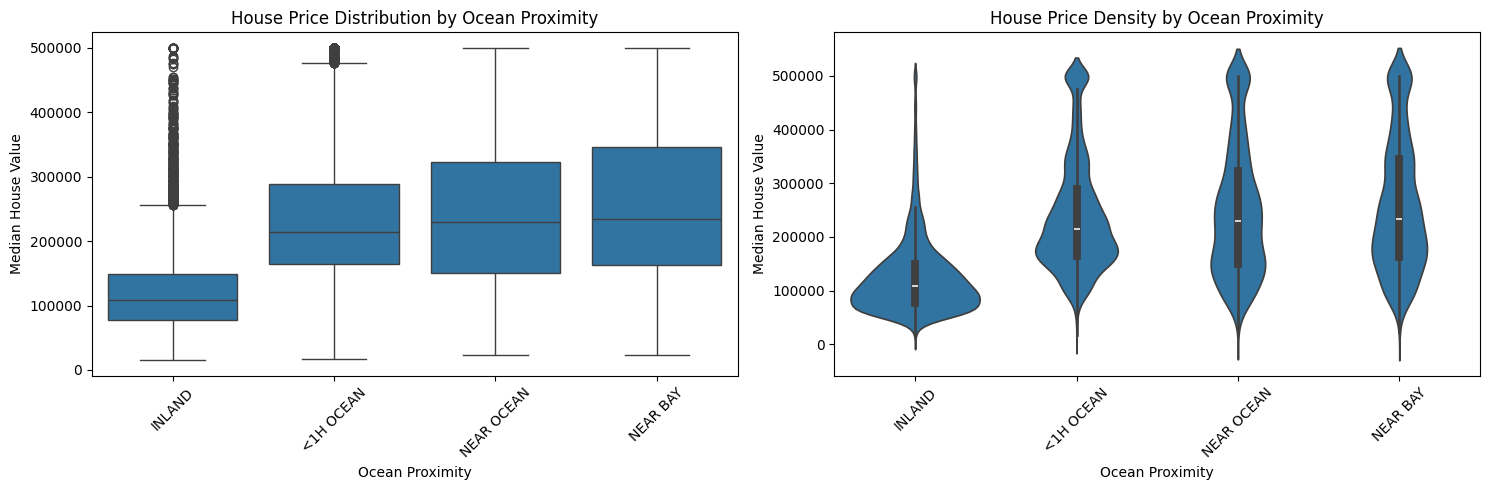

In [38]:
# create the basic statistical visualization
plt.figure(figsize=(15, 5))

# change the order of the categories show in the plot: from far to close to the ocean
ocean_proximity_order = ['INLAND', '<1H OCEAN', 'NEAR OCEAN', 'NEAR BAY']
df_filtered['ocean_proximity'] = pd.Categorical(df_filtered['ocean_proximity'], categories=ocean_proximity_order)

# boxplot
plt.subplot(1, 2, 1)
sns.boxplot(x='ocean_proximity', y='median_house_value', data=df_filtered)
plt.title('House Price Distribution by Ocean Proximity')
plt.xlabel('Ocean Proximity')
plt.ylabel('Median House Value')
plt.xticks(rotation=45)

# violinplot
plt.subplot(1, 2, 2)
sns.violinplot(x='ocean_proximity', y='median_house_value', data=df_filtered)
plt.title('House Price Density by Ocean Proximity')
plt.xlabel('Ocean Proximity')
plt.ylabel('Median House Value')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


We can see that the house price is generally higher when the ocean proximity is closer.

Next, we can see the geographic distribution of house prices in California through scatter plot.



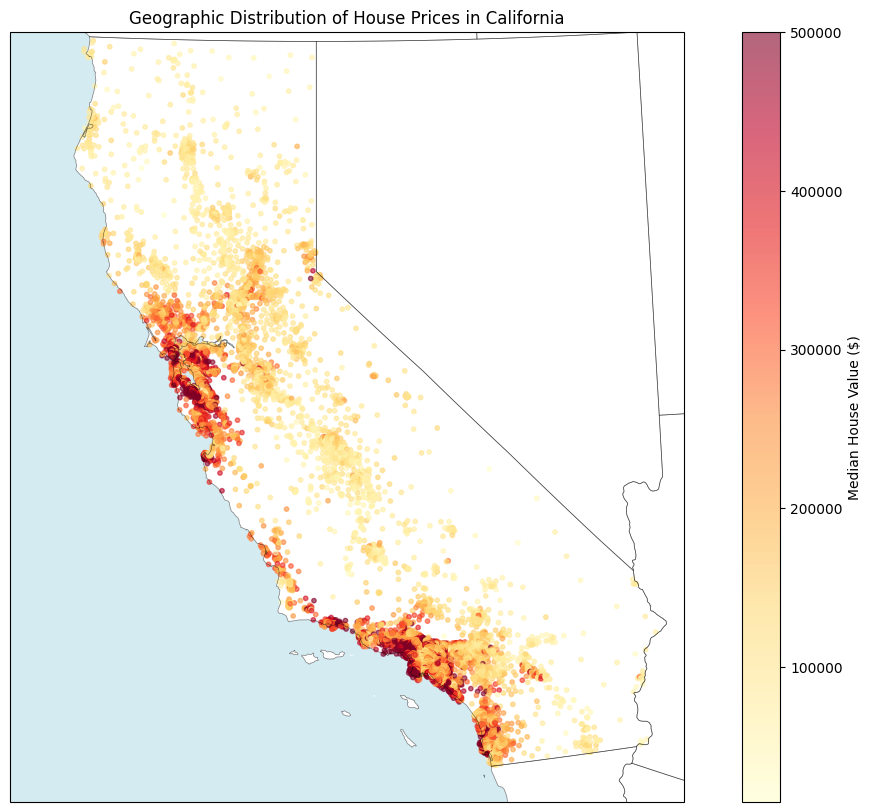

In [24]:
# create the figure and coordinate system
fig, ax = plt.subplots(figsize=(15, 10), 
                       subplot_kw={'projection': ccrs.AlbersEqualArea(
                           central_longitude=-120, central_latitude=37)})

# set the map range (California range)
ax.set_extent([-125, -114, 32, 42], ccrs.PlateCarree())

# we add the natural earth features
ax.add_feature(cfeature.OCEAN, facecolor='lightblue', alpha=0.5)
ax.add_feature(cfeature.LAND, facecolor='white')
ax.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5, alpha=0.5)

# draw the scatter plot of house prices
scatter = ax.scatter(df_filtered['longitude'], 
                    df_filtered['latitude'],
                    c=df_filtered['median_house_value'],
                    cmap='YlOrRd',
                    alpha=0.6,
                    s=10,
                    transform=ccrs.PlateCarree())  # important: specify the coordinate system of the data


plt.colorbar(scatter, label='Median House Value ($)')


plt.title('Geographic Distribution of House Prices in California')

plt.show()

From the scatter plot, we can see that the house prices are generally higher when the ocean proximity is closer. The distribution of data points also reveals a higher density of housing in coastal areas, suggesting these regions are more developed and populated compared to inland areas.

### Relationship between house prices and median income





We hypothesize that the house price is positively correlated with the median income. To test this hypothesis, we can see the relationship between house prices and median income through scatter plot.

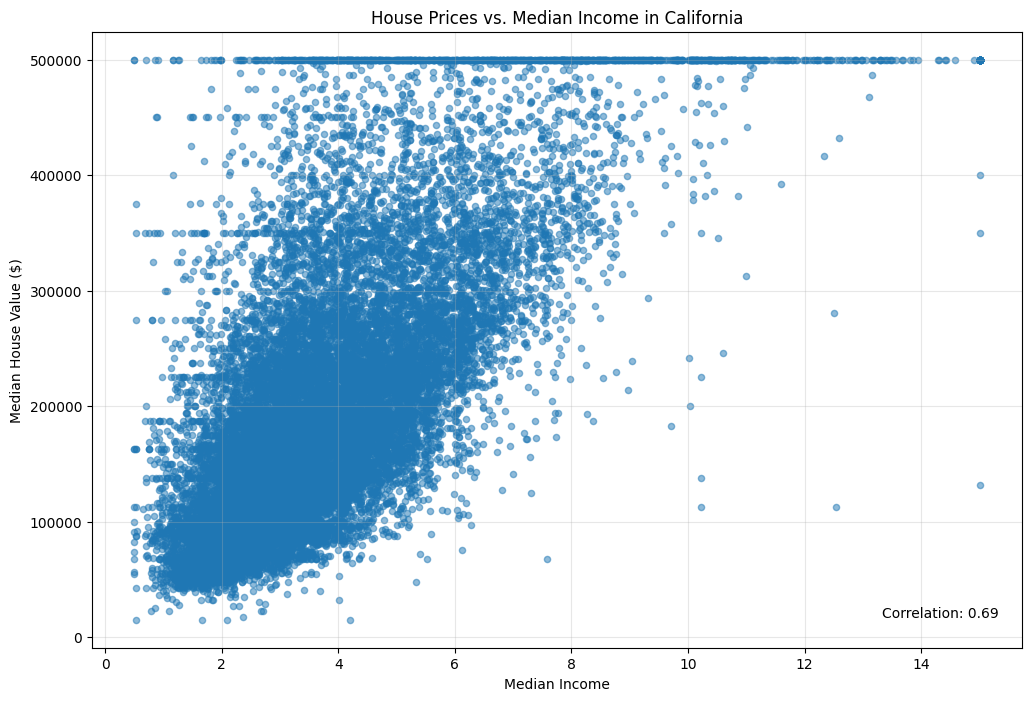

In [33]:
# create the simple scatter plot
plt.figure(figsize=(12, 8))

# draw the scatter plot
plt.scatter(df_filtered['median_income'], 
           df_filtered['median_house_value'],
           alpha=0.5,
           s=20)

# add the title and labels
plt.title('House Prices vs. Median Income in California')
plt.xlabel('Median Income')
plt.ylabel('Median House Value ($)')

# calculate the correlation coefficient
correlation = df_filtered['median_income'].corr(df_filtered['median_house_value'])
plt.text(0.85, 0.05, f'Correlation: {correlation:.2f}', 
         transform=plt.gca().transAxes)

plt.grid(True, alpha=0.3)
plt.show()

From the scatter plot, we can see that the house prices are generally higher when the median income is higher. And the correlation coefficient is 0.69, which indicates a strong positive correlation between the two variables.


## Conclusion

In this analysis, we have explored the relationship between house prices and coastal proximity in California. We have found that coastal properties command significantly higher prices compared to inland areas, with a 2 times difference in average house prices. This difference is statistically significant, as confirmed by the independent samples t-test.

We have also examined the relationship between house prices and median income, finding a positive correlation between the two variables. This suggests that as median income increases, so does the demand for housing in coastal areas, potentially driving up prices.

Overall, our analysis provides insights into how geographic location, particularly proximity to the ocean, influences house prices in California's diverse real estate market. These findings can be valuable for stakeholders in the real estate industry, policymakers, and investors seeking to understand and predict housing trends in coastal regions.